This is a test made by Leticia Campos Valente, currently Data Scientist I at Mundiale using a vehicles dataset to target vehicle 'conditions', in order to register the time of every 'normal' process in a routine of a Machine Learning professional to test physical GPU performance vs cloud computer performance. \
\
The archive have 1,35 GB of size, 26 columns and 426880 lines

# 1. Basic settings

## 1.1 Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from dask.diagnostics import ProgressBar

## 1.2 Pandas df display settings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

## 1.2 Matplotlib  display settings

In [3]:
%matplotlib inline

plt.close('all')

## 1.3 First time register

In [4]:
startnb = time.time()

# 2. Pre-processing

## 2.1 Dataset reading

In [5]:
startcsvread = time.time()
df = pd.read_csv('dataset/vehicles.csv')
endcsvread = time.time()-startcsvread

In [6]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [7]:
df.iloc[[100]] # Just to check how is a non empty line

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
100,7309192232,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,16590,2015.0,hyundai,sonata sport sedan 4d,good,NaN,gas,26655.0,clean,other,5NPE34AF8FH021634,fwd,NaN,sedan,white,https://images.craigslist.org/00d0d_65wNCfzhbw...,Carvana is the safer way to buy a car During t...,NaN,al,32.59,-85.48,2021-04-19T08:51:14-0500


In [8]:
df.shape

(426880, 26)

In [9]:
print(f'The process of the csv reading with {df.shape[0]} lines and {df.shape[1]} columns took {endcsvread} secconds')

The process of the csv reading with 426880 lines and 26 columns took 38.60023331642151 secconds


In [10]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

## 2.2 ETL

In [11]:
startetl = time.time()

### 2.2.1 Selection/Filtering

We can see that the 'county' column is fully empty, so we will remove it. Id, Url, region_url ,image url, and others below also not needed to predict 'conditions'. The price can be described by it's mechanical features already in dataset.

In [12]:
df.drop(columns=['id', 'url', 'region_url', 'VIN', 'image_url' ,'description', 'county','lat', 'long', 'posting_date', 'price', 'paint_color'], inplace=True)

In [13]:
df.shape[1] # The number of columns after filtering, previous was 26

14

In [14]:
df.iloc[[100]]

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
100,auburn,2015.0,hyundai,sonata sport sedan 4d,good,NaN,gas,26655.0,clean,other,fwd,NaN,sedan,al


### 2.2.2 Transformation

An opportunity for transformation was observed in the column 'cylinders', which is to transform it in a numerical type, instead of string as we're talking about numbers of cylinders. 

In [15]:
df['cylinders'].value_counts()

6 cylinders     94169
4 cylinders     77642
8 cylinders     72062
5 cylinders      1712
10 cylinders     1455
other            1298
3 cylinders       655
12 cylinders      209
Name: cylinders, dtype: int64

As it have a pattern, observed above, my solution is:

In [16]:
def cylinders_split(x):
    if type(x) == str:
        if x != 'other': 
            return x[0:2] # As the number comes first in the strings observed in value_counts
        else:
            return np.nan
    else:
        return x

In [17]:
df['cylinders'] = df['cylinders'].apply(cylinders_split)

In [18]:
df['cylinders'].value_counts()

6     94169
4     77642
8     72062
5      1712
10     1455
3       655
12      209
Name: cylinders, dtype: int64

In [19]:
df['cylinders'] = df['cylinders'].astype(np.float16) # For further outlier check

### 2.2.3 Imputing(Nulls part)

#### 2.2.3.1 Identification

In [20]:
df.isnull().sum()

region               0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       178976
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
state                0
dtype: int64

#### 2.2.3.2 Treatment

Starting by droping NaN 'condition' because of it being our target, we have:

In [21]:
df.dropna(subset=['condition'], inplace=True)

Size can be filled by mode and the type, so:

In [22]:
#First treating type normally by its general mode
df['type'].fillna(df['type'].mode(), inplace=True)

#As for the rest that fillna haven't reached
df['type'].fillna('unknown', inplace=True)


#Then the size, looking to car type column to return mode by type
mode = lambda x: x.mode() if np.issubdtype(x.dtype, np.number) else x.mode().iloc[0]
df['size'].fillna(df.groupby('type')['size'].transform(mode), inplace = True)


Knowing the model, year and manufacturer correctly, in the future, is important(my opinion), making incoerent if just fill, so:

In [23]:
df.dropna(subset=['year', 'model', 'manufacturer'], inplace=True)

Fuel, type of transmission, drive and cylinders may also be inputed by mode as it can be the same for multiple cars (knowledge from outside the dataset)

In [24]:
df['cylinders'].fillna(df['cylinders'].mode(), inplace = True)
#Again for the rest that fillna haven't reached
df['cylinders'].fillna('4', inplace = True)

df['fuel'].fillna(df['fuel'].mode(), inplace = True)
#Again for the rest that fillna haven't reached
df['fuel'].fillna('gas', inplace = True)

df['drive'].fillna(df['drive'].mode(), inplace = True)
#Again for the rest that fillna haven't reached
df['drive'].fillna('4wd', inplace = True)

df['transmission'].fillna(df['transmission'].mode(), inplace = True)
#Again for the rest that fillna haven't reached
df['transmission'].fillna('manual', inplace = True)


The best for odometer as a value for regression, recommended and explainable, is to use the mean in fillna. So:

In [25]:
df['odometer'].fillna(df['odometer'].mean(), inplace = True)

Finally for title status

In [26]:
df['title_status'].fillna(df['title_status'].mode(), inplace = True)
df['title_status'].fillna('clean', inplace = True)

In [27]:
print(df.isnull().sum())

region          0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
state           0
dtype: int64


In [28]:
df.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
27,auburn,2014.0,gmc,sierra 1500 crew cab slt,good,8.0,gas,57923.0,clean,other,4wd,full-size,pickup,al
28,auburn,2010.0,chevrolet,silverado 1500,good,8.0,gas,71229.0,clean,other,4wd,full-size,pickup,al
29,auburn,2020.0,chevrolet,silverado 1500 crew,good,8.0,gas,19160.0,clean,other,4wd,full-size,pickup,al
30,auburn,2017.0,toyota,tundra double cab sr,good,8.0,gas,41124.0,clean,other,4wd,full-size,pickup,al
31,auburn,2013.0,ford,f-150 xlt,excellent,6.0,gas,128000.0,clean,automatic,rwd,full-size,truck,al


### 2.2.4 Outliers

In [29]:
columns = list(df.columns)
print(columns)

['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'state']


Filtering, by observation (author view), columns that doesn't make sense making a outlier check, the new list:

In [30]:
unwanted_hist = ['iso_code', 'continent', 'location', 'date', 'year']
hist_list = [colstr for colstr in columns if colstr not in unwanted_hist]
df_hist = df[hist_list].copy()

In [31]:
df_hist.head()

,region,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
27,auburn,gmc,sierra 1500 crew cab slt,good,8.0,gas,57923.0,clean,other,4wd,full-size,pickup,al
28,auburn,chevrolet,silverado 1500,good,8.0,gas,71229.0,clean,other,4wd,full-size,pickup,al
29,auburn,chevrolet,silverado 1500 crew,good,8.0,gas,19160.0,clean,other,4wd,full-size,pickup,al
30,auburn,toyota,tundra double cab sr,good,8.0,gas,41124.0,clean,other,4wd,full-size,pickup,al
31,auburn,ford,f-150 xlt,excellent,6.0,gas,128000.0,clean,automatic,rwd,full-size,truck,al


array([[<AxesSubplot:title={'center':'odometer'}>]], dtype=object)

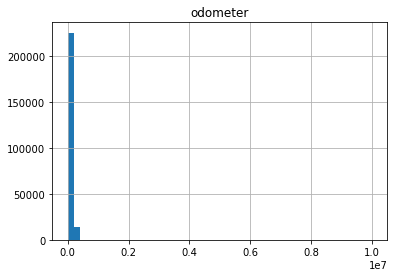

In [32]:
df_hist.hist(bins=50)

No worries.

In [33]:
endetl = time.time()-startetl

In [34]:
print(f'The ETL process took {endetl} secconds')

The ETL process took 2.4918878078460693 secconds


# 3. Model choice and Hyperparameters tuning

As condition determined as the target, we take a look at what do we have in order to decide the model

In [35]:
df['condition'].value_counts()

good         115347
excellent     96781
like new      19970
fair           5918
new            1130
salvage         532
Name: condition, dtype: int64

It's a classification problem, and some of classification models (no boosting) are DecisionTreeClassifier, Knn and RandomForest. The chosen one was Knn for it not being so performatic, and thus, will be better to test the hardware as proposed in the first line of this notebook. So

In [36]:
cls = KNeighborsClassifier()

In [37]:
cls.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

## 3.1 'n_neighbors' tuning using GridSearch

In [38]:
starttuning = time.time()

In [39]:
X = np.array(df.drop(['condition'], axis=1))
y = np.array(df['condition'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.33)

grid_param = {
    'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10],
}

grs = GridSearchCV(estimator=cls,
                     param_grid=grid_param,
                     scoring='f1_weighted',
                     cv=5,
                     n_jobs=-1, cv=5, return_train_score=True, verbose=2)

with ProgressBar():
    grs.fit(X_train, y_train)

gridresults = pd.DataFrame(grs.cv_results_)

SyntaxError: invalid syntax (Temp/ipykernel_788/2323476339.py, line 10)

In [ ]:
endtuning = time.time()-starttuning

In [ ]:
gridresults

In [ ]:
print(f'The Tuning process took {endtuning} secconds')

# Training + Complete Scoring

In [ ]:
def eval_metrics_classification(actual, pred):
    acy = accuracy_score(actual, pred)
    pcs = precision_score(actual, pred, average='macro')
    rcll = recall_score(actual, pred, average='macro')
    f1 = f1_score(actual, pred, average='macro')
    mcc = matthews_corrcoef(actual, pred)
    return acy, pcs, rcll, f1, mcc

In [ ]:
print(f'The process of the csv reading with {df.shape[0]} lines and {df.shape[1]} columns took {endcsvread} secconds')
print(f'The ETL process took {endetl} secconds')
print(f'The Tuning process took {endtuning} secconds')